In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import gc
import cv2
import random
import argparse
import numpy as np
import pandas as pd
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import wandb

from utils_.set_path import *
from utils_.set_seed import seed_everything
from utils_.loss import FocalLoss, LabelSmoothingLoss, F1Loss
from utils_.get_class_weight import calc_class_weight
from runner.pytorch_timm import TimmModel
# from runner.train_runner import CustomTrainer
# from data.dataset import CustomTrainDataset

In [2]:
seed_everything(909)

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_transforms(img_size, transforms):
    if transforms:
         return A.Compose([
                    # A.CenterCrop(height=375, width=200, p=1.0),
                    A.Resize(img_size[0], img_size[1]),
                    A.HorizontalFlip(p=0.5),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
                    ToTensorV2()
                    ])
    else:
        return A.Compose([
                    # A.CenterCrop(height=375, width=200, p=1.0),
                    A.Resize(img_size[0], img_size[1]),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
                    ToTensorV2()
                    ])

class CustomTrainDataset(Dataset):
    _mask_labels = {"mask1": 0, "mask2": 0, "mask3": 0, "mask4": 0, "mask5": 0, "incorrect_mask": 1, "normal": 2}
    _gender_labels = {"male": 0, "female": 1}

    def __init__(self, model_name, data_dir, folder_list, resize, transforms):
        self.model_name = model_name
        self.data_dir = data_dir
        self.folder_list = folder_list
        self.resize = resize
        self.transforms = transforms
        
        self.image_paths = []
        self.mask_labels, self.gender_labels, self.age_labels, self.ages = [], [], [], []
        self.setup()
        

    def setup(self):
        for folder in self.folder_list:
            img_folder = os.path.join(self.data_dir, folder) # ('/workspace/data/train/image', 000004_male_Asian_54)
            for file_name in os.listdir(img_folder): # ('mask1.jpg', 'mask2.jpg', ... )
                _file_name, _ = os.path.splitext(file_name) # ('mask1', '.jpg')
                img_path = os.path.join(self.data_dir, folder, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                
                _, gender, _, age = folder.split("_")
                # mask_label = self._mask_labels[_file_name]                
                gender_label = self._gender_labels[gender]
                age = int(age)
                age_label = 0 if age < 30 else 1 if age < 60 else 2
                
                self.image_paths.append(img_path)
                if self.model_name == 'Mask': self.mask_labels.append(0)
                elif self.model_name == 'Gender': self.gender_labels.append(gender_label)
                elif self.model_name == 'Age': 
                    self.age_labels.append(age_label)
                    self.ages.append(age)

    def __getitem__(self, index):
        assert self.transforms is not None, "transform 을 주입해주세요"
        
        image = cv2.imread(self.image_paths[index])
        trfm = get_transforms(self.resize, self.transforms)
        image = trfm(image=image)['image']
        
        if self.model_name == 'Mask':
            mask_label = self.mask_labels[index]
            return image, mask_label
        elif self.model_name == 'Gender':
            gender_label = self.gender_labels[index]
            return image, gender_label
        elif self.model_name == 'Age':
            age_label = self.age_labels[index]
            return image, age_label
        
    def __len__(self):
        return len(self.image_paths)

class CustomTestDataset(Dataset):
    def __init__(self, img_paths, resize, transforms=None):
        self.img_paths = img_paths
        self.resize = resize
        self.transforms = transforms

    def __getitem__(self, index):
        image = cv2.imread(self.img_paths[index])
        trfm = get_transforms(self.resize, self.transforms)
        image = trfm(image=image)['image']
            
        return image

    def __len__(self):
        return len(self.img_paths)

In [4]:
model_name = 'Age'
gc.collect() # python 자원 관리 
torch.cuda.empty_cache() # gpu 자원관리

data_dir = TRAIN_IMG_FOLDER_PATH
model_dir = '/opt/ml/level1_imageclassification-cv-16/geunuk/models'
train_df = pd.read_csv(TRAIN_CSV_PATH)
train_, val_ = train_test_split(train_df, test_size=0.2, random_state=909)

val_dataset = CustomTrainDataset(model_name, data_dir, val_['path'].values, [256, 192], transforms=False)
valid_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle=False, num_workers=8)


In [5]:
import torch.nn as nn
import torchvision.models as models
import timm

class TimmModel(nn.Module):
    def __init__(self, model, num_classes, pretrained=True):
        super().__init__()
        self.num_classes = num_classes
        self.pretrained = pretrained
        
        self.model = timm.create_model(model, pretrained=self.pretrained)
        self.fc = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                               nn.Linear(1000, 512),
                               nn.Dropout(p=0.2, inplace=True),
                               nn.Linear(512, self.num_classes),
                               )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

In [6]:
device = torch.device('cuda')
model = TimmModel('resnet34', num_classes=3, pretrained=True).to(device)
model.load_state_dict(torch.load(f"{model_dir}/Project6/Age_[resnet34]_[score0.7966]_[loss0.3827].pt"))
model = nn.DataParallel(model)


In [7]:
class CustomTrainer():
    def __init__(self, args = None, model = None, valid_dataloader = None, optimizer = None, scheduler = None, criterion = None, device = None):
        self.args = args
        self.model = model
        self.valid_dataloader = valid_dataloader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.device = device 

    def validation(self):
        self.model.eval()
        val_loss = []
        preds, trues = [], []
        print('='*25, f'VALID', '='*25)
        with torch.no_grad():
            for imgs, labels in tqdm(iter(self.valid_dataloader), bar_format='{l_bar}{bar:50}{r_bar}{bar:-10b}'):
                imgs = imgs.float().to(self.device)
                labels = labels.to(self.device)

                logit = self.model(imgs)

                loss = self.criterion(logit, labels)

                val_loss.append(loss.item())

                preds += logit.argmax(1).detach().cpu().numpy().tolist()
                trues += labels.detach().cpu().numpy().tolist()

            _val_loss = np.mean(val_loss)
            _val_acc = f1_score(trues, preds, average='macro')

        return _val_loss, _val_acc

In [8]:
trainer = CustomTrainer(model = model, valid_dataloader = valid_dataloader, criterion=None, device=device)

In [9]:
targets_img = None
preds, targets = torch.Tensor().to(device), torch.Tensor().to(device)
prediction = []
with torch.no_grad():
    for X, y in tqdm(valid_dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        pred = pred.argmax(dim=1)
        indices = (pred != y).nonzero().squeeze()

        if indices.nelement() != 0:
            target_img = X[indices]
            if target_img.dim() == 3:
                target_img = target_img.unsqueeze(dim=0)
            
            if targets_img is None:
                targets_img = target_img
            else:
                targets_img = torch.cat((targets_img, target_img), dim=0)
            ps = pred[indices]
            ys = y[indices]
            if ys.dim() == 0:
                ys = ys.unsqueeze(dim=0)
                ps = ps.unsqueeze(dim=0)
            preds = torch.cat((preds, ps))
            targets = torch.cat((targets, ys))

In [10]:
from sklearn.metrics import f1_score

In [11]:

misprediction_count = {
    (0, 1) : 0,
    (0, 2) : 0,
    (1, 0) : 0,
    (1, 2) : 0,
    (2, 0) : 0,
    (2, 1) : 0
}
misprediction_tostring = {
    (0, 1) : "pred <30, label 30to60",
    (0, 2) : "pred <30, label >60",
    (1, 0) : "pred 30to60, label <30",
    (1, 2) : "pred 30to60, label >60",
    (2, 0) : "pred >60, label <30",
    (2, 1) : "pred >60, label 30to60",
}

In [12]:
for pred, label in tqdm(zip(preds, targets)):
    misprediction_count[(pred.item(), label.item())] += 1

In [13]:
test = np.array(list(zip(preds.to(torch.uint8).cpu(), targets.to(torch.uint8).cpu())))
indices = np.where((test[:, 0] == 0) & (test[:, 1] == 1))
indices = indices[0]

In [14]:
misprediction_count

{(0, 1): 188, (0, 2): 9, (1, 0): 153, (1, 2): 128, (2, 0): 6, (2, 1): 88}

In [15]:
for key, value in misprediction_count.items():
    print(f'{misprediction_tostring[key]}: {value}')

pred <30, label 30to60: 188
pred <30, label >60: 9
pred 30to60, label <30: 153
pred 30to60, label >60: 128
pred >60, label <30: 6
pred >60, label 30to60: 88


In [16]:
c1 = torch.zeros(1, 256, 192) + 0.229
c2 = torch.zeros(1, 256, 192) + 0.224
c3 = torch.zeros(1, 256, 192) + 0.225
std_cn = torch.cat((c1, c2, c3), dim=0)

c1 = torch.zeros(1, 256, 192) + 0.485
c2 = torch.zeros(1, 256, 192) + 0.456
c3 = torch.zeros(1, 256, 192) + 0.406
std_mean = torch.cat((c1, c2, c3), dim=0)

In [17]:
import matplotlib.pyplot as plt

In [18]:
# class_dict = {0: "male", 1:"female"}
class_dict = {0: "<30", 1:"30to60", 2:">60"}

In [19]:
class_counts_train = {i:0 for i in range(3)}
class_counts_val = {i:0 for i in range(3)}

In [20]:
for img, target in val_dataset:
    class_counts_val[target] += 1

In [21]:
class_counts_train

{0: 0, 1: 0, 2: 0}

In [22]:
class_counts_val

{0: 1687, 1: 1750, 2: 343}

In [23]:
for img, target in train_dataset:
    class_counts_train[target]+=1

NameError: name 'train_dataset' is not defined

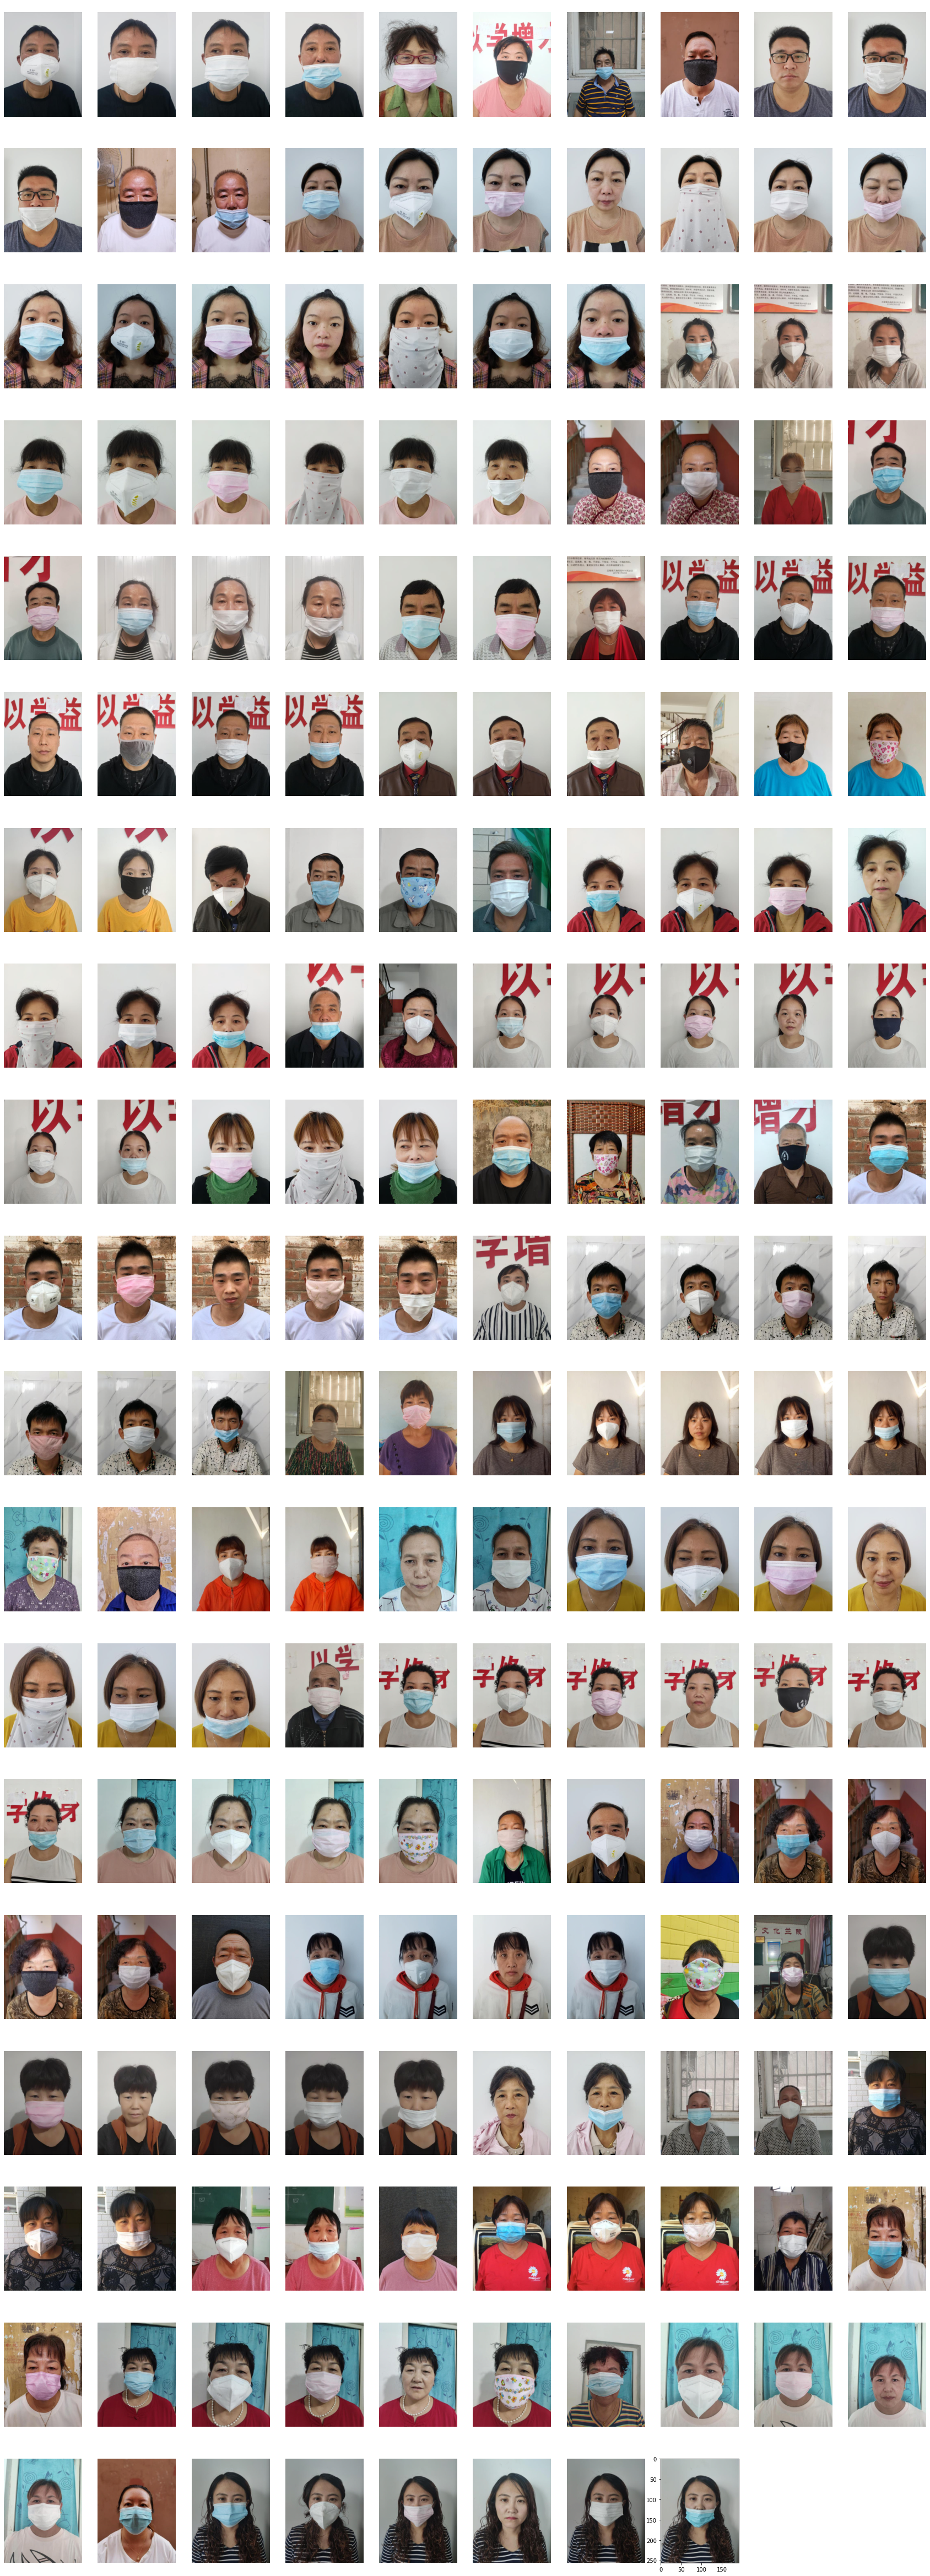

In [24]:
test = np.array(list(zip(preds.to(torch.uint8).cpu(), targets.to(torch.uint8).cpu())))
indices = np.where((test[:, 0] == 0) & (test[:, 1] == 1))
indices = indices[0]

plt.figure(figsize=(30, 90))
for idx, (img, pred, targ) in enumerate(zip(targets_img[indices], preds[indices], targets[indices])):
    plt.axis("off")
    plt.subplot(20, 10, idx+1)
    plt.title(f"pred:{class_dict[pred.item()]}, label:{class_dict[targ.item()]}", color="white")
    plt.imshow((img.cpu() * std_cn + std_mean).permute(1, 2, 0).flip(2))

In [ ]:
test = np.array(list(zip(preds.to(torch.uint8).cpu(), targets.to(torch.uint8).cpu())))
indices = np.where((test[:, 0] == 0) & (test[:, 1] == 2))
indices = indices[0]

plt.figure(figsize=(30, 90))
for idx, (img, pred, targ) in enumerate(zip(targets_img[indices], preds[indices], targets[indices])):
    plt.axis("off")
    plt.subplot(20, 10, idx+1)
    plt.title(f"pred:{class_dict[pred.item()]}, label:{class_dict[targ.item()]}",color="white")
    plt.imshow((img.cpu() * std_cn + std_mean).permute(1, 2, 0).flip(2))

In [ ]:
test = np.array(list(zip(preds.to(torch.uint8).cpu(), targets.to(torch.uint8).cpu())))
indices = np.where((test[:, 0] == 1) & (test[:, 1] == 0))
indices = indices[0]

plt.figure(figsize=(30, 90))
for idx, (img, pred, targ) in enumerate(zip(targets_img[indices], preds[indices], targets[indices])):
    plt.axis("off")
    plt.subplot(20, 10, idx+1)
    plt.title(f"pred:{class_dict[pred.item()]}, label:{class_dict[targ.item()]}", color="white")
    plt.imshow((img.cpu() * std_cn + std_mean).permute(1, 2, 0).flip(2))

In [ ]:
test = np.array(list(zip(preds.to(torch.uint8).cpu(), targets.to(torch.uint8).cpu())))
indices = np.where((test[:, 0] == 1) & (test[:, 1] == 2))
indices = indices[0]

plt.figure(figsize=(30, 90))
for idx, (img, pred, targ) in enumerate(zip(targets_img[indices], preds[indices], targets[indices])):
    plt.axis("off")
    plt.subplot(20, 10, idx+1)
    plt.title(f"pred:{class_dict[pred.item()]}, label:{class_dict[targ.item()]}", color="white")
    plt.imshow((img.cpu() * std_cn + std_mean).permute(1, 2, 0).flip(2))

In [ ]:
test = np.array(list(zip(preds.to(torch.uint8).cpu(), targets.to(torch.uint8).cpu())))
indices = np.where((test[:, 0] == 2) & (test[:, 1] == 0))
indices = indices[0]

plt.figure(figsize=(30, 90))
for idx, (img, pred, targ) in enumerate(zip(targets_img[indices], preds[indices], targets[indices])):
    plt.axis("off")
    plt.subplot(20, 10, idx+1)
    plt.title(f"pred:{class_dict[pred.item()]}, label:{class_dict[targ.item()]}", color="white")
    plt.imshow((img.cpu() * std_cn + std_mean).permute(1, 2, 0).flip(2))

In [ ]:
test = np.array(list(zip(preds.to(torch.uint8).cpu(), targets.to(torch.uint8).cpu())))
indices = np.where((test[:, 0] == 2) & (test[:, 1] == 1))
indices = indices[0]

plt.figure(figsize=(30, 90))
for idx, (img, pred, targ) in enumerate(zip(targets_img[indices], preds[indices], targets[indices])):
    plt.axis("off")
    plt.subplot(20, 10, idx+1)
    plt.title(f"pred:{class_dict[pred.item()]}, label:{class_dict[targ.item()]}", color="white")
    plt.imshow((img.cpu() * std_cn + std_mean).permute(1, 2, 0).flip(2))